# Clasificacion Parkinson con Centro de masa

In [1]:
class MagnificacionCentroDeMasa:
    def __init__(self,path,video,tipo):
        self.path = path
        self.video = video
        self.tipo = tipo
        
    def SacarFotogramas(self):
        import subprocess
        subprocess.call(['bash', 'sacar_fotogramas(tipo).sh', self.path, self.video[:-1], self.video[:-1], self.tipo])
        #subprocess.call(['bash', 'sacar_fotogramas.sh', self.path, self.video[:-1]) normal
    
    def SortDir(self,path):
        import os
        import numpy as np
        frames = os.listdir(path)

        indices=[]

        for i in frames:
            indices.append(int(i[10:13]))


        sort_indices = np.sort(indices)
        sort_frames = []       
        for i in sort_indices:
                if i<10:
                    sort_frames.append("fotograma-00"+str(i)+".png") 
                elif i<100:  
                     sort_frames.append("fotograma-0"+str(i)+".png")
                else:
                     sort_frames.append("fotograma-"+str(i)+".png")
        return sort_frames
    
    def CentroDeMasa(self,img):
        from scipy import ndimage
        import numpy as np
        mass_center_tuple = ndimage.measurements.center_of_mass(img)
        if np.isnan(mass_center_tuple[0]) and np.isnan(mass_center_tuple[1]):

            mass_center = [0,0]
            return mass_center

        else:

            mass_center=[int(mass_center_tuple[0]),int(mass_center_tuple[1])]
            return mass_center
    
    def Region(self):
        import subprocess
        import cv2
        import numpy as np
        Frames_Originales = self.SortDir(self.path + self.video)
        carpeta_de_region = 'region'
        carpeta_de_region_color = 'region_color'
        subprocess.call(['mkdir', carpeta_de_region])
        subprocess.call(['mkdir', 'Segmentacion'])
        subprocess.call(['mkdir', carpeta_de_region_color])
        fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()

        for frame in Frames_Originales:

            img = cv2.imread(self.path + self.video + frame)
            Segmentacion = fgbg.apply(img)
            cv2.imwrite(self.path + 'Segmentacion/' + frame , Segmentacion)
            y, x = img.shape[:2]
            copia_1 = np.zeros((y,x,3))
            copia_2 = np.zeros((y,x,3))
            cm = self.CentroDeMasa(Segmentacion)
            copia_1[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101] = img[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101]
            copia_2[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101] = 255
            cv2.imwrite(self.path + carpeta_de_region + '/' + frame, copia_2)
            cv2.imwrite(self.path + carpeta_de_region_color + '/' + frame, copia_1)
            
    def AumentarVector(self,b, a, alfa):
        if b == 0:
            return b, int(a*alfa)
        elif a == 0:
            return int(b*alfa), a
        else:
            c = alfa*a
            d = b*c/a
            return int(d), int(c)
            
    def Aumento(self, alfa):
        import subprocess
        import cv2
        import numpy as np
        cm_normal = []
        cm_aumentado = []
        Frames_Region = self.SortDir(self.path + 'region')
        total_de_frames = len(Frames_Region)
        carpeta_de_aumento = 'Aumento'
        subprocess.call(['mkdir', carpeta_de_aumento])
        for i,frame in enumerate(Frames_Region):
            if i != total_de_frames-1:
                img_1 = cv2.imread(self.path + 'region' + '/' + Frames_Region[i], 0)
                img_1_color = cv2.imread(self.path + 'region' + '/' + Frames_Region[i])
                img_2 = cv2.imread(self.path + 'region' + '/' + Frames_Region[i+1], 0)
                y, x = img_1.shape[:2]
                img_1_aumentada = np.zeros((y,x,3))
                cm_1 = np.array(self.CentroDeMasa(img_1))
                cm_2 = np.array(self.CentroDeMasa(img_2))
                if np.average(cm_1) != 0 and np.average(cm_2) != 0:
                    cm  = cm_2 - cm_1
                    y_cm, x_cm = self.AumentarVector(cm[0], cm[1], alfa)
                    y_cm = y_cm + cm_1[0]
                    x_cm = x_cm + cm_1[1]
                    try:
                        cm_normal.append(cm_1)
                        cm_aumentado.append([y_cm, x_cm])
                        img_1_aumentada[y_cm - 100:y_cm + 101, x_cm - 100:x_cm + 101] = img_1_color[cm_1[0] - 100:cm_1[0] + 101,cm_1[1] - 100:cm_1[1] + 101]
                        cv2.imwrite(self.path + carpeta_de_aumento + '/' + frame, img_1_aumentada)
                    except ValueError:
                        cv2.imwrite(self.path + carpeta_de_aumento + '/' + frame, img_1_color)
                else:
                    cv2.imwrite(self.path + carpeta_de_aumento + '/' + frame, img_1_color)
        subprocess.call(['rm','-r', self.video])
        !rm -r Aumento
        !rm -r region
        !rm -r region_color
        !rm -r Segmentacion
        cm_normal, cm_aumentado = np.array(cm_normal), np.array(cm_aumentado)
        a, b = cm_aumentado.shape
        a = int(a/2)
        return cm_aumentado[a-35:a+36,0]
    
    def Normalizar(self, array):
        import numpy as np
        maximo = np.max(array)
        array = array*1/float(maximo)
        return array
    
    def AumentoAutomatico(self,alfa):
        self.SacarFotogramas()
        self.Region()
        cm = self.Aumento(alfa)
        return self.Normalizar(cm)

In [5]:
Magnificacion = MagnificacionCentroDeMasa('/home/brayan/Documentos/Stsiva_code/','std2.mp4/','std/')

In [6]:
cm = Magnificacion.AumentoAutomatico(4)
print cm.shape

/home/brayan/anaconda2/lib/python2.7/site-packages/scipy/ndimage/measurements.py:1328: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


(71,)


<function matplotlib.pyplot.show>

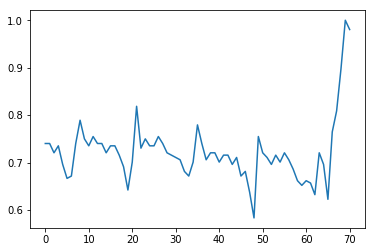

In [8]:
import matplotlib.pyplot as plt
plt.plot(cm)
plt.show

In [9]:
import os
videos_pk = frames = os.listdir('/home/brayan/Vídeos/pk/')
videos_std = frames = os.listdir('/home/brayan/Vídeos/std/')

X = []
y = []

for video in videos_pk:
    Magnificacion = MagnificacionCentroDeMasa('/home/brayan/Documentos/Stsiva_code/', video + '/', 'pk/')
    cm = Magnificacion.AumentoAutomatico(8)
    X.append(cm)
    y.append(0)
    
for video in videos_std:
    Magnificacion = MagnificacionCentroDeMasa('/home/brayan/Documentos/Stsiva_code/', video + '/', 'std/')
    cm = Magnificacion.AumentoAutomatico(8)
    X.append(cm)
    y.append(1)

In [10]:
import numpy as np
print('x.shape: ', np.array(X).shape, 'y.shape: ', np.array(y).shape)
X = np.array(X)
y = np.array(y)

('x.shape: ', (14, 71), 'y.shape: ', (14,))


In [198]:
def pasar_text(nombre,X,y):
    f = open(nombre,'a')
    h,w = X.shape
    for i in range(h):
        linea = str(y[i]+1) + ' '
        for j in range(w):
            linea = linea + str(j+1) + ':' + str(X[i,j]) + ' '
        #print(linea)
        f.write(linea + '\n')
    f.close()

In [199]:
pasar_text('clasificacion_alfa:8', X, y)

In [28]:
from sklearn.neighbors import KNeighborsClassifier 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score

classifier = KNeighborsClassifier(n_neighbors=1)  

s = cross_val_score(classifier, X, y, cv=KFold(3, shuffle=True), scoring=make_scorer(accuracy_score))
print s
print "accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s))


[1.   0.6  0.75]
accuracy 0.783 (+/- 0.16499)
